In [1]:
from pylineage.multi_lineage_simulator import MultiLineageSimulator
import numpy as np
from abianalysis.volume import Volume

from itertools import combinations

from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from abianalysis.hierarchy import make_hierarchy
from pylineage.layout import h_tree_layout, tree_layout
from pylineage.color import TreeColorMap
from abianalysis.plot.max_projection import MaxProjection

from pylineage.cell import Cell
from pylineage.property import Property
from umap import UMAP
from scipy.spatial.distance import squareform, pdist

In [10]:
%%time
sim = MultiLineageSimulator(n_dims=3, n_divisions=100000 - 100, n_roots=100,
                            n_genes=200, symmetric_prob=0.2)
sim.run()
original_root = list(sim.root.children)[0]

leaves = list(original_root.leaves())
all_cells = list(original_root.descendants())

idx_prop = Property()
for i, leaf in enumerate(leaves):
    leaf.voxel_index = i

leaf_exp = np.vstack([leaf.expression for leaf in leaves])
leaf_pos = np.vstack([leaf.expression for leaf in leaves])

sim_volume = Volume('simulated', leaf_exp, leaf_pos)

all_exp = np.vstack([cell.expression for cell in all_cells])

CPU times: user 7.4 s, sys: 124 ms, total: 7.52 s
Wall time: 7.53 s


CPU times: user 363 ms, sys: 73.2 ms, total: 436 ms
Wall time: 440 ms


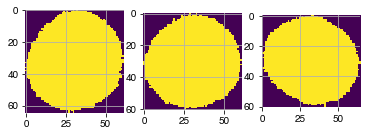

In [11]:
%%time
positions = sim.grid._content.values()
idx = np.array([pos.index for pos in positions])
cells = [pos.item for pos in positions]

mi = np.min(idx, 0)
ma = np.max(idx, 0)
array = np.zeros(tuple([*ma - mi + 1, sim.n_genes]))
for i, cell in zip(idx - mi, cells):
    array[tuple(i)] = cell.expression

fig, axs = plt.subplots(1,3)
for i in range(3):
    axs[i].imshow(np.any(array != 0, (i, 3)), interpolation='none')

In [12]:
class BlockAdapter:
    def __init__(self, block_size):
        self.block_size = block_size
        
    def to_block_idx(self, grid_idx):
        return np.array(grid_idx) // block_size
    
    def block_shape(self, matrix_shape):
        return self.to_block_idx(matrix_shape) + 1

In [13]:
%%time

adapter = BlockAdapter(3)

block_size = 3
pooled_array = np.zeros((
    array.shape[0] // block_size + 1,
    array.shape[1] // block_size + 1,
    array.shape[2] // block_size + 1,
    sim.n_genes,
))


for x in np.arange(0, array.shape[0], block_size):
    for y in np.arange(0, array.shape[1], block_size):
        for z in np.arange(0, array.shape[2], block_size):
            mean = np.mean(array[x:x+block_size, 
                                 y:y+block_size, 
                                 z:z+block_size],
                           axis=(0, 1, 2))
            pooled_array[x // block_size, y // block_size, z // block_size] = mean

CPU times: user 236 ms, sys: 7.16 ms, total: 243 ms
Wall time: 98.6 ms


In [14]:
selection = np.any(pooled_array != 0, 3) > 0
expression = pooled_array[selection]
positions = np.argwhere(selection)

In [15]:
%%time
volume = Volume(age='simulated',
                voxel_indices=np.copy(positions), 
                expression=np.copy(expression))
volume.preprocess()
hierarchy = make_hierarchy(volume, depth=4)
full_hierarchy = make_hierarchy(volume)

CPU times: user 35.3 s, sys: 5.62 s, total: 40.9 s
Wall time: 6 s


In [16]:
def get_spatial_spread(voxel_ids):
    """The average distance between two voxels"""
    if len(voxel_ids) == 1:
        return 0
    voxel_positions = volume.voxel_indices[voxel_ids]
    
    # pdist  returns every order once (so A-B and B-A are not repeated)
    pairwise_distances = pdist(voxel_positions)
    return np.mean(pairwise_distances)

def get_depth_vs_spatial_spread(hierarchy):
    # Every node in the hierarchy corresponds to a collection of voxels.
    max_depth = max(node.depth for node in hierarchy.leaves())
    depth_vs_spatial_spread = {i: [] for i in range(max_depth + 1)}
    for node in hierarchy.descendants():
        depth_vs_spatial_spread[node.depth].append(node.spatial_spread())
    return depth_vs_spatial_spread

def plot_region_sizes(ax, hierarchy):
    depths, region_sizes = zip(*get_depth_vs_spatial_spread(hierarchy).items())
    means = np.array([np.mean(r) for r in region_sizes]) / 1000
    std = np.array([np.std(r) for r in region_sizes]) / 1000
    ax.fill_between(depths, means - std, means + std, facecolor='lightgrey')
    ax.plot(depths, means, c='k')

Hierarchy...
Volumes...
Region variance...


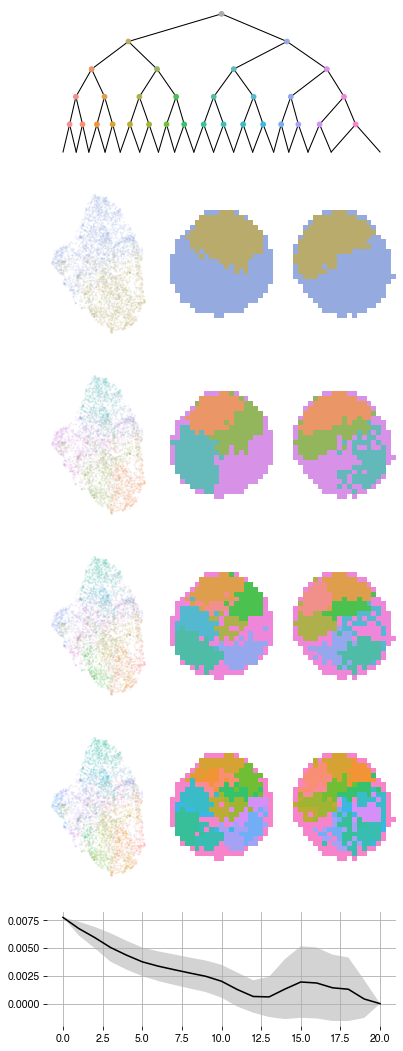

In [17]:
from abianalysis.plot.side import Side

n_rows = 4

width = 6
height = 3 * width

voxel_size = 200

fig = plt.figure(figsize=(width, height), dpi=75)
spec = fig.add_gridspec(ncols=3, 
                        nrows=n_rows+2, 
                        width_ratios=[2, 2, 2], 
                        height_ratios=[1, 1, 1, 1, 1, 0.75])

print('Hierarchy...')
ax = fig.add_subplot(spec[0,:])
col = TreeColorMap().get_color_map(hierarchy)
tree_pos = tree_layout(hierarchy)
for n in hierarchy.descendants():
    if (n.is_leaf and (n.parent.children[0] == n or n.parent.children[-1] == n) 
            or (not n.is_leaf and not n.is_root)):
        ax.plot(*zip(tree_pos[n.parent], tree_pos[n]),
                c='k', lw=1, zorder=0)
x, y = np.array([tree_pos[n] 
                 for n in hierarchy.descendants()
                 if not n.is_leaf]).T
ax.axis('off')
ax.scatter(x, y, s=20, 
           c=[col[n] for n in hierarchy.descendants()
              if not n.is_leaf])
ax.invert_yaxis()

def plot_view(ax, depth, side):
    stack = MaxProjection.from_hierarchy(hierarchy, depth, side)
    ax.imshow(stack.to_image(col), interpolation='antialiased', rasterized=True)
    ax.set_frame_on(False)
#     ax.add_collection(stack.get_outlines(depth, side))
    ax.axis(False)

expression = np.stack([n.expression for n in hierarchy.leaves()])
pcs = UMAP(n_components=2).fit_transform(expression)

print('Volumes...')
for i in range(n_rows):

    ax = fig.add_subplot(spec[i + 1, 0])
    ax.scatter(*pcs.T, s=1, alpha=.1,
               c=[col[n.ancestor_at_depth(i + 1)] 
                  for n in hierarchy.leaves()],
               rasterized=True, zorder=10)
    ax.axis('off')

    
    # Nodes are used for both front and side views

    depth = i + 1
    
    ax = fig.add_subplot(spec[i+1, 1])    
    plot_view(ax, depth, Side.SAGITTAL)

    ax = fig.add_subplot(spec[i+1, 2], sharey=ax)
    plot_view(ax, depth, Side.FRONTAL)


print('Region variance...')
ax = fig.add_subplot(spec[5,:])

plot_region_sizes(ax, full_hierarchy)

fig.savefig('../imgs/sim_column.pdf', dpi=300)